# An analysis on the US Immigration
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import psycopg2
from sql_queries import airports_table_insert, demographics_table_insert, immigrations_table_insert, temperatures_table_insert
from IPython import display

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Source: I94 Immigration Data
This data comes from the US National Tourism and Trade Office.

<font color="red">Note:</font> This is quite a big file. It takes a few minutes to process it.

In [3]:
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
df_i94immigration = pd.read_sas(fname, 'sas7bdat', encoding="ISO-8859-1")
df_i94immigration.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


#### Source: World Temperature Data
This dataset came from Kaggle. You can read more about it [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data)

In [4]:
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
df_weather = pd.read_csv(fname)

In [5]:
# Filter to only temperatures in the US
df_weather_US = df_weather[df_weather["Country"] == "United States"]
df_weather_US.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
47555,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W
47556,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W
47557,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W
47558,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W
47559,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W


#### Source: U.S. City Demographics Data
This data comes from OpenSoft. You can read more about it [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)

In [6]:
df_demographics_US = pd.read_csv("./us-cities-demographics.csv", delimiter=";")
df_demographics_US.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Source: Airport Code Table
This is a simple table of airport codes and corresponding cities. It comes from [here](https://datahub.io/core/airport-codes#data)

In [7]:
df_airports_codes = pd.read_csv("./airport-codes_csv.csv")
df_airports_codes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

In [7]:
df_i94immigration.describe()

,cicid,i94yr,i94mon,i94cit,i94res,arrdate,i94mode,depdate,i94bir,i94visa,count,biryear,admnum
count,3.096313e+06,3096313.0,3096313.0,3.096313e+06,3.096313e+06,3.096313e+06,3.096074e+06,2.953856e+06,3.095511e+06,3.096313e+06,3096313.0,3.095511e+06,3.096313e+06
mean,3.078652e+06,2016.0,4.0,3.049069e+02,3.032838e+02,2.055985e+04,1.073690e+00,2.057395e+04,4.176761e+01,1.845393e+00,1.0,1.974232e+03,7.082885e+10
std,1.763278e+06,0.0,0.0,2.100269e+02,2.085832e+02,8.777339e+00,5.158963e-01,2.935697e+01,1.742026e+01,3.983910e-01,0.0,1.742026e+01,2.215442e+10
min,6.000000e+00,2016.0,4.0,1.010000e+02,1.010000e+02,2.054500e+04,1.000000e+00,1.517600e+04,-3.000000e+00,1.000000e+00,1.0,1.902000e+03,0.000000e+00
25%,1.577790e+06,2016.0,4.0,1.350000e+02,1.310000e+02,2.055200e+04,1.000000e+00,2.056100e+04,3.000000e+01,2.000000e+00,1.0,1.962000e+03,5.603523e+10
50%,3.103507e+06,2016.0,4.0,2.130000e+02,2.130000e+02,2.056000e+04,1.000000e+00,2.057000e+04,4.100000e+01,2.000000e+00,1.0,1.975000e+03,5.936094e+10
75%,4.654341e+06,2016.0,4.0,5.120000e+02,5.040000e+02,2.056700e+04,1.000000e+00,2.057900e+04,5.400000e+01,2.000000e+00,1.0,1.986000e+03,9.350987e+10
max,6.102785e+06,2016.0,4.0,9.990000e+02,7.600000e+02,2.057400e+04,9.000000e+00,4.542700e+04,1.140000e+02,3.000000e+00,1.0,2.019000e+03,9.991557e+10


In [8]:
df_weather_US.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,661524.000000,661524.00000
mean,13.949335,1.08955
std,9.173337,1.15068
min,-25.163000,0.04000
25%,7.787000,0.30000
50%,14.922000,0.52400
75%,21.081000,1.64600
max,34.379000,10.51900


In [9]:
df_demographics_US.describe()

,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,Count
count,2891.000000,2.888000e+03,2.888000e+03,2.891000e+03,2878.000000,2.878000e+03,2875.000000,2.891000e+03
mean,35.494881,9.732843e+04,1.017696e+05,1.989668e+05,9367.832523,4.065360e+04,2.742543,4.896377e+04
std,4.401617,2.162999e+05,2.315646e+05,4.475559e+05,13211.219924,1.557491e+05,0.433291,1.443856e+05
min,22.900000,2.928100e+04,2.734800e+04,6.321500e+04,416.000000,8.610000e+02,2.000000,9.800000e+01
25%,32.800000,3.928900e+04,4.122700e+04,8.042900e+04,3739.000000,9.224000e+03,2.430000,3.435000e+03
50%,35.300000,5.234100e+04,5.380900e+04,1.067820e+05,5397.000000,1.882200e+04,2.650000,1.378000e+04
75%,38.000000,8.664175e+04,8.960400e+04,1.752320e+05,9368.000000,3.397175e+04,2.950000,5.444700e+04
max,70.500000,4.081698e+06,4.468707e+06,8.550405e+06,156961.000000,3.212500e+06,4.980000,3.835726e+06


In [11]:
df_airports_codes.describe()

,elevation_ft
count,48069.000000
mean,1240.789677
std,1602.363459
min,-1266.000000
25%,205.000000
50%,718.000000
75%,1497.000000
max,22000.000000


### Cleaning Steps
Document steps necessary to clean the data

#### I94Immigration
Obtain only valid CIT codes for processing and have the I94Immigration filtered.

In [8]:
with open("./I94_SAS_Labels_Descriptions.SAS") as file:
    content = file.readlines()

content = [x.strip() for x in content]                              # Splits each line of the file into an array
i94_port_codes_full_arr = content[302:962]                          # Extracts only the CODES
i94_port_codes_full_arr_splitted_ports = [port_codes_full.split("=") for port_codes_full in i94_port_codes_full_arr]

# EXTRACT CODES [eg.: ALC]
i94_port_codes = [i94_port_code[0].replace("'", "").strip() for i94_port_code in i94_port_codes_full_arr_splitted_ports]

# EXTRACT CITY AND STATE [eg.: ALCAN, AK]
i94_port_locations = [i94_port_code[1].replace("'", "").strip() for i94_port_code in i94_port_codes_full_arr_splitted_ports]
i94_port_cities = [i94_port_location.split(',')[0] for i94_port_location in i94_port_locations]
i94_port_states = [i94_port_location.split(',')[-1] for i94_port_location in i94_port_locations]

# PANDAS DATAFRAME
df_i94_port_locations = pd.DataFrame({ "i94_port_code": i94_port_codes, "i94_port_city": i94_port_cities, "i94_port_state": i94_port_states })

# DROP IRREGULAR (These ports aren't complying with the CODE CITY STATE format and should be dropped)
df_i94_port_locations_irregular = df_i94_port_locations[df_i94_port_locations['i94_port_city'] == df_i94_port_locations['i94_port_state']]
df_i94_port_locations_irregular = df_i94_port_locations_irregular.drop_duplicates(subset = ["i94_port_code"])

# DROP IRREGULAR PORTS FROM THE FULL I94-IMMIGRATION DATASET
df_i94immigration_filtered = df_i94immigration[~df_i94immigration["i94port"].isin(df_i94_port_locations_irregular["i94_port_code"].values)]
df_i94immigration_filtered.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
5,18.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MI,20555.0,...,NaN,M,1959.0,09302016,NaN,NaN,AZ,9.247104e+10,00602,B1
6,19.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,NJ,20558.0,...,NaN,M,1953.0,09302016,NaN,NaN,AZ,9.247140e+10,00602,B2


In [9]:
# RENAMING COLUMNS
df_i94immigration_filtered = df_i94immigration_filtered.rename(columns={
    'i94yr': 'year',
    'i94mon': 'month',
    'i94cit': 'cit',
    'i94res': 'res',
    'port': 'iata',
    'i94port': 'iata',
    'i94mode': 'mode',
    'i94addr': 'addr',
    'i94bir': 'bir',
    'i94visa': 'visa'
})

df_i94immigration_filtered = df_i94immigration_filtered[[
    'cicid', 'year', 'month', 'cit', 'res', 'iata', 'arrdate',
    'mode', 'addr', 'depdate', 'bir', 'visa', 'count', 'dtadfile',
    'entdepa', 'entdepd', 'matflag', 'biryear', 'dtaddto', 'gender', 'airline', 
    'admnum', 'fltno', 'visatype'
]]

df_i94immigration_filtered.dropna(inplace=True)

df_i94immigration_filtered.head()

,cicid,year,month,cit,res,iata,arrdate,mode,addr,depdate,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
12,27.0,2016.0,4.0,101.0,101.0,BOS,20545.0,1.0,MA,20549.0,...,G,O,M,1958.0,04062016,M,LH,9.247876e+10,00422,B1
13,28.0,2016.0,4.0,101.0,101.0,ATL,20545.0,1.0,MA,20549.0,...,G,O,M,1960.0,04062016,F,LH,9.247890e+10,00422,B1
14,29.0,2016.0,4.0,101.0,101.0,ATL,20545.0,1.0,MA,20561.0,...,G,O,M,1954.0,09302016,M,AZ,9.250378e+10,00614,B2
15,30.0,2016.0,4.0,101.0,101.0,ATL,20545.0,1.0,NJ,20578.0,...,G,O,M,1967.0,09302016,M,OS,9.247021e+10,00089,B2
16,31.0,2016.0,4.0,101.0,101.0,ATL,20545.0,1.0,NY,20611.0,...,G,O,M,1973.0,09302016,M,OS,9.247129e+10,00089,B2


#### US Weather (Temperature)
Dropping NA (Empty/null) entries 

In [10]:
df_weather_US.dropna(inplace=True)
df_weather_US = df_weather_US.rename(columns={
    'df': 'timestamp',
    'AverageTemperature': 'average_temperature',
    'AverageTemperatureUncertainty': 'average_temperature_uncertainty',
    'City': 'city',
    'Country': 'country',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
})
df_weather_US.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,dt,average_temperature,average_temperature_uncertainty,city,country,latitude,longitude
47555,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W
47556,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W
47557,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W
47558,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W
47559,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W


#### US City Demographics
- Dropping NA (Empty/null) IATA_CODE entries 
- Renaming columns

In [11]:
df_demographics_US.dropna(inplace=True)
df_demographics_US = df_demographics_US.rename(columns={
    'City': 'city',
    'State': 'state',
    'Median Age': 'median_age',
    'Male Population': 'male_population',
    'Female Population': 'female_population',
    'Total Population': 'total_population',
    'Number of Veterans': 'number_of_veterans',
    'Foreign-born': 'foreign_born',
    'Average Household Size': "average_household_size",
    'State Code': 'state_code',
    'Race': 'race',
    'Count': 'count'
})
df_demographics_US.head()

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Airports
Dropping NA (Empty/null) IATA_CODE entries 

In [12]:
df_airports_codes.dropna(subset=['iata_code'], inplace=True)
df_airports_codes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
223,03N,small_airport,Utirik Airport,4.0,OC,MH,MH-UTI,Utirik Island,K03N,UTK,03N,"169.852005, 11.222"
440,07FA,small_airport,Ocean Reef Club Airport,8.0,NaN,US,US-FL,Key Largo,07FA,OCA,07FA,"-80.274803161621, 25.325399398804"
594,0AK,small_airport,Pilot Station Airport,305.0,NaN,US,US-AK,Pilot Station,NaN,PQS,0AK,"-162.899994, 61.934601"
673,0CO2,small_airport,Crested Butte Airpark,8980.0,NaN,US,US-CO,Crested Butte,0CO2,CSE,0CO2,"-106.928341, 38.851918"
1088,0TE7,small_airport,LBJ Ranch Airport,1515.0,NaN,US,US-TX,Johnson City,0TE7,JCY,0TE7,"-98.62249755859999, 30.251800537100003"


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

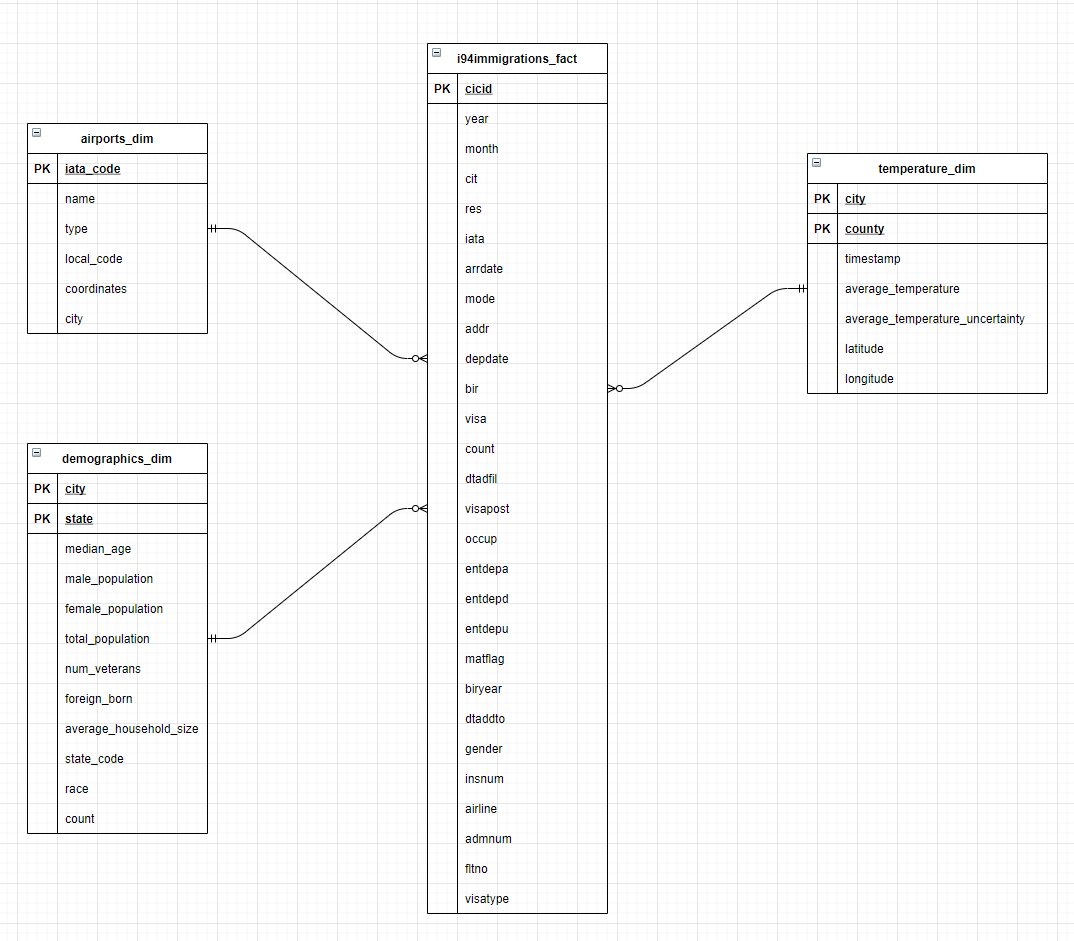

In [13]:
display.Image('./capstone_ER.png')

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

- Execute `create_tables.py`

- Insert data from source to target tables

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [14]:
import configparser

config = configparser.ConfigParser()
config.read_file(open('config/dwh.cfg'))
conn = psycopg2.connect(
  "host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values())
)
cur = conn.cursor()

In [15]:
# Merge i94_port_location (city, state) to airports_codes
df_airports_codes = df_airports_codes.merge(df_i94_port_locations, left_on="iata_code", right_on="i94_port_code").rename(columns={'i94_port_city': 'city', 'i94_port_state': 'state'})
df_airports_codes.drop(columns=["i94_port_code"], inplace=True)
df_airports_codes = df_airports_codes[[
    "iata_code",
    "name",
    "city",
    "state",
    "type",
    "local_code",
    "coordinates",    
    "elevation_ft",
    "continent",
    "iso_country",
    "iso_region",
    "municipality",
    "gps_code"
]]

df_airports_codes.head()

,iata_code,name,city,state,type,local_code,coordinates,elevation_ft,continent,iso_country,iso_region,municipality,gps_code
0,TKI,Tokeen Seaplane Base,TOKEEN,AK,seaplane_base,57A,"-133.32699585, 55.9370994568",NaN,NaN,US,US-AK,Tokeen,57A
1,BKF,Lake Brooks Seaplane Base,No PORT Code (BKF),No PORT Code (BKF),seaplane_base,5Z9,"-155.77699279785, 58.554798126221",36.0,NaN,US,US-AK,Katmai National Park,5Z9
2,AXB,Maxson Airfield,ALEXANDRIA BAY,NY,small_airport,89NY,"-75.90034, 44.312002",340.0,NaN,US,US-NY,Alexandria Bay,89NY
3,FRE,Fera/Maringe Airport,FRESNO,CA,small_airport,NaN,"159.576996, -8.1075",NaN,OC,SB,SB-IS,Fera Island,AGGF
4,ANZ,Angus Downs Airport,ANZALDUAS,TX,small_airport,NaN,"132.2748, -25.0325",1724.0,OC,AU,AU-NT,Angus Downs Station,NaN


In [56]:
# Create tables
%run create_tables

In [ ]:
# Insert immigrations
# df_i94immigration_filtered_top5 = df_i94immigration_filtered.head()
for index, row in df_i94immigration_filtered.iterrows():
    cur.execute(immigrations_table_insert, list(row.values))
    conn.commit()

In [46]:
# df_i94immigration_filtered_top5 = df_i94immigration_filtered.head()
df_i94immigration_filtered_top5.values

array([[27.0, 2016.0, 4.0, 101.0, 101.0, 'BOS', 20545.0, 1.0, 'MA',
        20549.0, 58.0, 1.0, 1.0, '20160401', 'G', 'O', 'M', 1958.0,
        '04062016', 'M', 'LH', 92478763830.0, '00422', 'B1'],
       [28.0, 2016.0, 4.0, 101.0, 101.0, 'ATL', 20545.0, 1.0, 'MA',
        20549.0, 56.0, 1.0, 1.0, '20160401', 'G', 'O', 'M', 1960.0,
        '04062016', 'F', 'LH', 92478900330.0, '00422', 'B1'],
       [29.0, 2016.0, 4.0, 101.0, 101.0, 'ATL', 20545.0, 1.0, 'MA',
        20561.0, 62.0, 2.0, 1.0, '20160401', 'G', 'O', 'M', 1954.0,
        '09302016', 'M', 'AZ', 92503781430.0, '00614', 'B2'],
       [30.0, 2016.0, 4.0, 101.0, 101.0, 'ATL', 20545.0, 1.0, 'NJ',
        20578.0, 49.0, 2.0, 1.0, '20160401', 'G', 'O', 'M', 1967.0,
        '09302016', 'M', 'OS', 92470209430.0, '00089', 'B2'],
       [31.0, 2016.0, 4.0, 101.0, 101.0, 'ATL', 20545.0, 1.0, 'NY',
        20611.0, 43.0, 2.0, 1.0, '20160401', 'G', 'O', 'M', 1973.0,
        '09302016', 'M', 'OS', 92471289230.0, '00089', 'B2']], dtype=obj

In [ ]:
# Insert temperatures
for index, row in df_weather_US.iterrows():
    cur.execute(temperatures_table_insert, list(row.values))
    conn.commit()

In [ ]:
# Insert demographics
for index, row in df_demographics_US.iterrows():
    cur.execute(demographics_table_insert, list(row.values))
    conn.commit()

In [ ]:
# Insert airports_codes
for index, row in df_airports_codes.iterrows():
    cur.execute(airports_table_insert, list(row.values))
    conn.commit()

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
def quality_check(df, description, table_name):
  """
    :param df: Pandas dataframe
    :param description: Dataframe name/description
    :param table_name: table name
  """
  result = df.count()
  if result == 0:
    print(f"Data quality check failed for {description} with zero records")
  else:
    cur.execute(f"SELECT COUNT(*) FROM {table_name}")
    conn.commit()

    if cur.rowcount < 1:
      print(f"Data quality check failed for {table_name} with zero records")
    else:
      if result != cur.rowcount:
        print(f"Data quality check failed. Number of entries in {description} does not match with {table_name}")
    
  return 0

quality_check(df_airports_codes, "df_airports_code", "airport_dim")
quality_check(df_demographics_US, "df_demographics_US", "demographic_dim")
quality_check(df_weather_US, "df_weather_US", "temperature_dim")
quality_check(df_i94immigration_filtered, "df_i94immigration_filtered", "immigration_fact")

#### 4.3 Data dictionary 

In the README.md file

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.
 
In the README.md file